In [149]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [150]:
import numpy as np
import pandas as pd

In [151]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [152]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [153]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [154]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [155]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [156]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [157]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [158]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [159]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [160]:
columns = inspector.get_columns('station')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

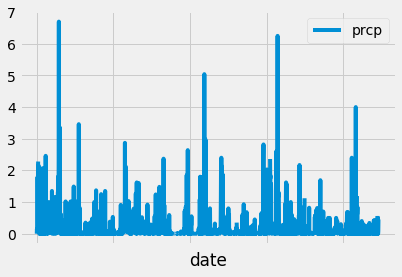

In [238]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date, = session.query(func.max(Measurement.date)).all()
one_yr_date = pd.to_datetime(max_date[0]) - dt.timedelta(days=366)
                                                         
# Perform a query to retrieve the data and precipitation scores
last_12_months_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(func.strftime(Measurement.date) >= str(one_yr_date)).\
    order_by(Measurement.date.asc()).all()
#order_by(func.count(Measurement.station).desc())

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_12_months_prcp, columns = ('date', 'prcp'))
prcp_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot()

In [162]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [163]:
# Design a query to show how many stations are available in this dataset?
count_stations, = session.query(func.count(Station.id)).all()
print(f'There are {count_stations[0]} stations')

There are 9 stations


In [164]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#station_count_sql = engine.execute('SELECT station, count(id) as row_count FROM Measurement GROUP BY station').fetchall()
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [240]:
stations = session.query(Station.station).all()
stations

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [165]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
calc = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
temp_station, = session.query(*calc).filter(Measurement.station == 'USC00519281').all()
print(f'Min temp: {temp_station[0]}, Max temp: {temp_station[1]}, Avg temp: {temp_station[2]}')

Min temp: 54.0, Max temp: 85.0, Avg temp: 71.66378066378067


In [172]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_temp = session.query(Measurement.tobs).\
                filter(Measurement.station == 'USC00519281', func.strftime(Measurement.date) >= str(one_yr_date)).all()

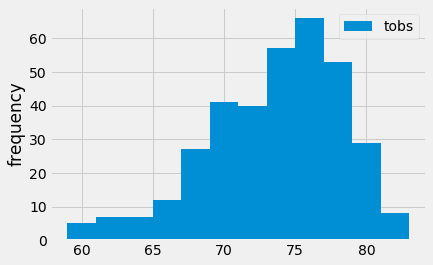

In [179]:
temps = [result[0] for result in last_12_temp]

fig2, ax2 = plt.subplots()
ax2.hist(temps, bins=12, label="tobs")
ax2.set_ylabel("frequency")
ax2.legend()
plt.show()

In [125]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


[(62.0, 69.57142857142857, 74.0)]


In [205]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2012-01-14', '2012-01-26'))

[(58.0, 70.71428571428571, 78.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [206]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= '2012-01-14').filter(Measurement.date <= '2012-01-28').\
        filter(Measurement.station == Station.station).group_by(Measurement.station).all()
rainfall_df = pd.DataFrame(rainfall, columns = ('Station', 'Station Name', 'Latitude', 'Longitude', 'Elevation', 'Total Rainfall'))
rainfall_df

,Station,Station Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.36
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.42
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.07
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.30
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.33
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,2.66
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.64
7,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.13
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.28


In [204]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

## Optional Challenge Assignment

In [249]:
# calculate the daily normals for your trip
start_month = '01-'
start_day = 14
dates = []

for num in range(14):
    dates.append(start_month + str(start_day))
    start_day += 1
# push each tuple of calculations into a list called `normals`
normals = []
for date in dates:
    calc, = daily_normals(date)
    normals.append(calc)
print(normals)

58.0
56.0
54.0
61.0
57.0
60.0
61.0
61.0
60.0
57.0
58.0
61.0
61.0
59.0
[(58.0, 69.52631578947368, 77.0), (56.0, 69.31372549019608, 78.0), (54.0, 68.62962962962963, 80.0), (61.0, 69.07407407407408, 76.0), (57.0, 68.63157894736842, 77.0), (60.0, 68.26315789473684, 78.0), (61.0, 68.86666666666666, 78.0), (61.0, 70.14545454545454, 76.0), (60.0, 69.26415094339623, 76.0), (57.0, 69.50909090909092, 79.0), (58.0, 68.76271186440678, 78.0), (61.0, 67.94915254237289, 75.0), (61.0, 70.58620689655173, 77.0), (59.0, 68.56896551724138, 75.0)]


In [252]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ('min','avg','max'), index = dates)
normals_df

,min,avg,max
01-14,58.0,69.526316,77.0
01-15,56.0,69.313725,78.0
01-16,54.0,68.629630,80.0
01-17,61.0,69.074074,76.0
01-18,57.0,68.631579,77.0
01-19,60.0,68.263158,78.0
01-20,61.0,68.866667,78.0
01-21,61.0,70.145455,76.0
01-22,60.0,69.264151,76.0
01-23,57.0,69.509091,79.0


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
